In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1️.데이터 로드
df = pd.read_csv('/content/drive/MyDrive/기계학습프로그래밍/실습 파일/TSLA.csv')

# 필요한 열만 사용 (Open, High, Low → Close 예측)
df = df[['Open', 'High', 'Low', 'Close']].dropna()

In [2]:
# === 2. 정규화 ===
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df[['Open', 'High', 'Low']])
y_scaled = scaler_y.fit_transform(df[['Close']])

In [3]:
# === 3. 시퀀스 데이터 생성 ===
window = 6
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])      # 6일치 입력
    y.append(y_scaled[i+window])        # 다음날 종가 예측
X, y = np.array(X), np.array(y)

In [4]:
# === 4. 훈련/테스트 분할 (8:2) ===
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [11]:
# 5. RNN 모델
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, activation='tanh', input_shape=(window, 3)),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# 6. LSTM 모델
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=(window, 3)),
    tf.keras.layers.LSTM(32, activation='tanh'),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')


In [13]:
# 7. 모델 학습
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=1
)

history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    verbose=1
)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2876e-04 - val_loss: 0.0274
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.3576e-06 - val_loss: 0.0164
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7113e-06 - val_loss: 0.0160
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9476e-06 - val_loss: 0.0097
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8706e-06 - val_loss: 0.0079
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7606e-06 - val_loss: 0.0054
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2287e-06 - val_loss: 0.0062
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4761e-06 - val_loss: 0.0034
Epoch 9/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.8934e-06 - val_loss: 0.0026
Epoch 10/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 2.2991e-06 - val_loss: 0.0022
Epoch 11/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.9204e-06 - val_loss: 0.0017
Epoch 1

In [14]:
# 8. 테스트 예측
pred_rnn = model_rnn.predict(X_test)
pred_lstm = model_lstm.predict(X_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


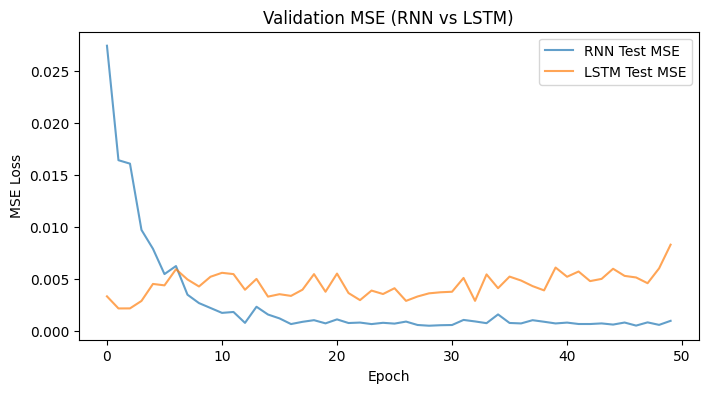

In [17]:
# 9. MSE 시각화
plt.figure(figsize=(8,4))
plt.plot(history_rnn.history['val_loss'], label='RNN Test MSE', alpha=0.7)
plt.plot(history_lstm.history['val_loss'], label='LSTM Test MSE', alpha=0.7)
plt.title('Validation MSE (RNN vs LSTM)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

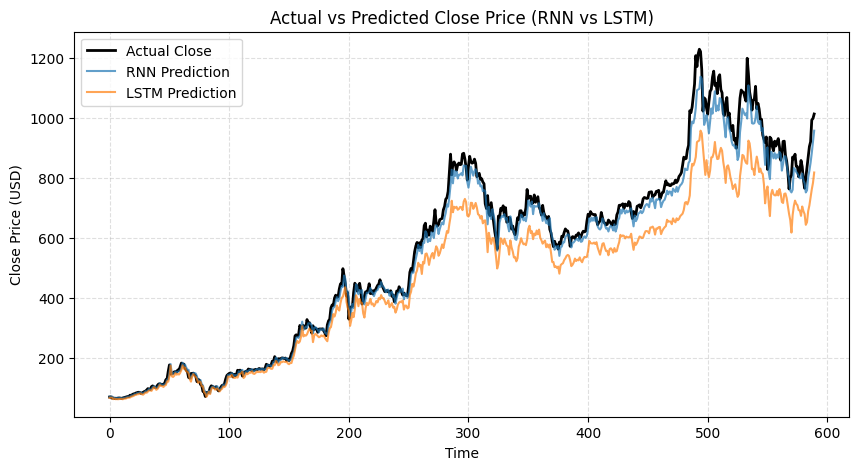

In [18]:
# 10. 실제값 vs 예측값 시각화
# inv : 스케일링된 값을 원래 가격 단위로 되돌리는 복원을 의미함
y_test_inv = scaler_y.inverse_transform(y_test)
pred_rnn_inv = scaler_y.inverse_transform(pred_rnn)
pred_lstm_inv = scaler_y.inverse_transform(pred_lstm)

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Actual Close', color='black', linewidth=2)
plt.plot(pred_rnn_inv, label='RNN Prediction', alpha=0.7)
plt.plot(pred_lstm_inv, label='LSTM Prediction', alpha=0.7)
plt.title('Actual vs Predicted Close Price (RNN vs LSTM)')
plt.xlabel('Time')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()